# David Hyldgaard, Frederik Jarosch von Schweder, Espen Haugland Mæland

# 1. Get the bigger picture

### In this notebook we'll try to predict the box office revenue based on a dataset from TMDB. We'll try to predict the revenue based on the features given in the dataset.

# 2. Get the data

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# 3. Get insight in the data

In [4]:
import os
os.listdir("data")

['submission_2_lgb.csv',
 'test.csv',
 'submission_1_lgb_2-2.csv',
 'submission_3_lgb.csv',
 'submission_4_lgb.csv',
 '.ipynb_checkpoints',
 'sample_submission-Copy1.csv',
 'submission_1_voting.csv',
 'submission_2_voting.csv',
 'submission_5_lgb.csv',
 'submission_3_voting.csv',
 'train.csv']

In [5]:
#Reads the csv files and creates a dataframe

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### We already see that some colums will be dropped, original title for sure (since we have english title), homepage (can be useful for external data), imdb_id and poster path will be removed
### It is also clear that we need to do a lot of datacleaning and many decisions has to be made as how to handle data modulation. 

In [7]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

We can already see we need to find a way to deal with null values

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [10]:
len(train), len(test)

(3000, 4398)

### It's worth noting that the dataset is relatively small and smaller than the test set. we'll therefore need to prepare the data as good as posible and get as many features as posible into our model from this relativly small dataset. 

## Let's take a look at some of the variables, more specifically: budget, runtime and popularity


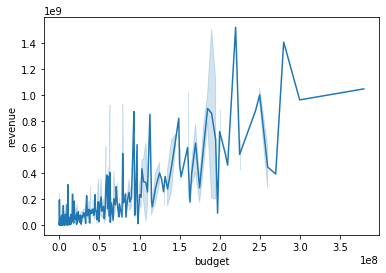

In [11]:
ax = sns.lineplot(x='budget', y='revenue', data=train)

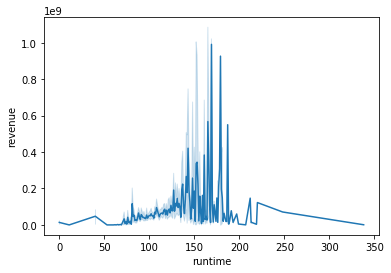

In [12]:
ax = sns.lineplot(x='runtime', y='revenue', data=train)

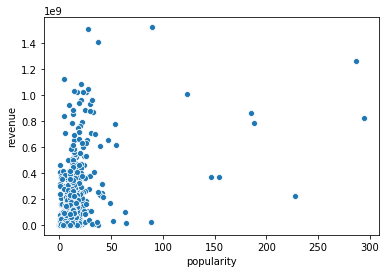

In [13]:
ax = sns.scatterplot(x='popularity', y='revenue', data=train)

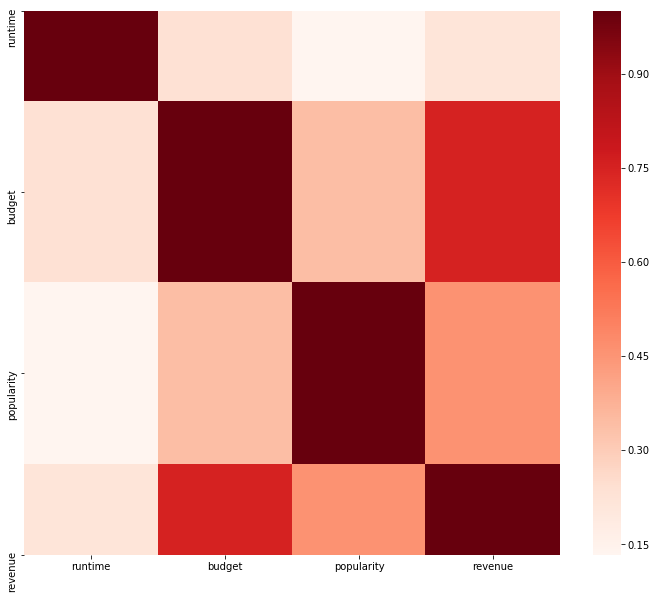

In [14]:
features = ['runtime', 'budget', 'popularity', 'revenue']
plt.subplots(figsize=(12,10))
corr = train[features].corr()
sns.heatmap(corr, cmap="Reds")

#Heatmap er bedre
#fig = sns.PairGrid(train[['runtime', 'budget', 'popularity', 'revenue']].dropna()) #dropna dropper nullverdier
#fig.map_upper(plt.scatter, color = 'red')
#fig.map_lower(plt.scatter, color = 'm')
#fig.map_diag(sns.distplot, bins = 30)

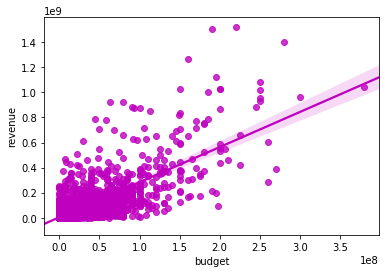

In [15]:
ax = sns.regplot(x="budget", y="revenue", data=train, color ="m", ) 
#1e9 = 10^9

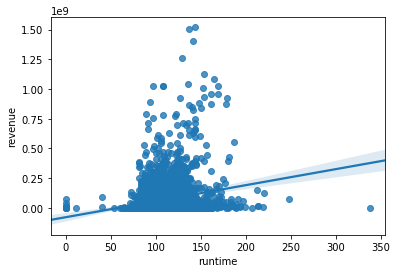

In [16]:
ax = sns.regplot(x="runtime", y="revenue", data=train)

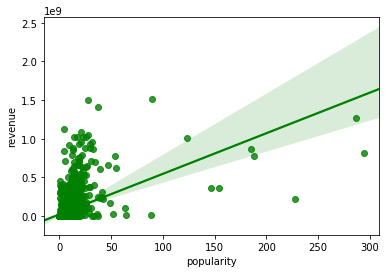

In [17]:
ax = sns.regplot(x="popularity", y="revenue", data=train, color ="g")

### We see that budget and popularity has a big impact on revenue earned. Runtime also has some impact, although not as much as the previous two 

# 4.Data cleaning and Data prep

### This function will be used to clean up some of the features:

In [18]:
#returns a list with total count of elements in a specific feature
def featureCounter(dataset, feature, name):
    counter = []
    for i in dataset[feature]:
        if(not(pd.isnull(i))):
            counter.append(len(eval(i)))
        else:
            counter.append(0)
    return counter

### Removing some features, that are useless to us in this assigment:

In [19]:
train_relevant = train.filter(['budget', 'belongs_to_collection', 'genres', 'original_language', 'overview','popularity', 'production_companies',
                                            'production_countries', 'release_date', 'runtime', 'tagline', 'Keywords', 'cast', 'crew','revenue'], axis =1)
#test.drop(columns=['homepage', 'original_title', 'imdb_id', 'poster_path', 'status'], axis =1, inplace=True)
train_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
budget                   3000 non-null int64
belongs_to_collection    604 non-null object
genres                   2993 non-null object
original_language        3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
tagline                  2403 non-null object
Keywords                 2724 non-null object
cast                     2987 non-null object
crew                     2984 non-null object
revenue                  3000 non-null int64
dtypes: float64(2), int64(2), object(11)
memory usage: 351.7+ KB


### As expected, there are many null values

In [20]:
train_relevant.isnull().sum().sum()

3526

### Missing by feature:

In [21]:
pd.set_option("display.max_rows", None) # To print all rows below

In [22]:
train_relevant.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
revenue                     0
release_date                0
popularity                  0
original_language           0
budget                      0
dtype: int64

### With closer inspection we see that there are few variables that have missing values

### We're gonna clean up all the null by making some changes to how we look at the data

## Starting with the easiest: Runtime

In [23]:
#As there are very few entries missing I will use the mean to fill the blanks
train_relevant['runtime'] = train['runtime'].fillna(train['runtime'].mean())

In [24]:
train_relevant['runtime'].isnull().sum()

0

## Looking at belongs_to_collection 

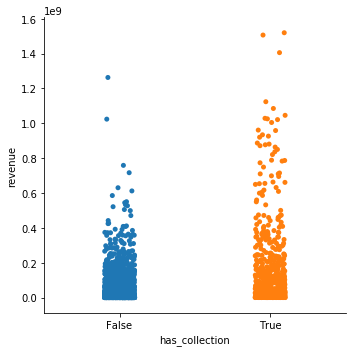

In [25]:
# Lets make a boolean column with information on weather the movie is part of a collection or not
train_relevant['has_collection'] = ~train_relevant['belongs_to_collection'].isnull()

sns.catplot(x='has_collection', y='revenue', data=train_relevant);

### We see that a movie being a part of a collection increases revenue

## Lets go to the next feature: Genres!

In [26]:
#Let's look at how many genres a movie has
train_relevant['genre_count'] = featureCounter(train_relevant, 'genres', 'gn')    

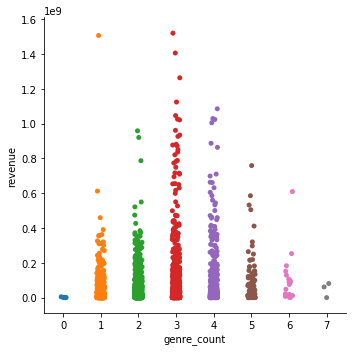

In [27]:
#Let's try and plot it using catplot again...
sns.catplot(x ='genre_count' , y = 'revenue', data=train_relevant)

### We see that number of genres also makes revenue

## Overview


### there's not alot of movies missing an overview, but I would guess that a movie with an overview would do better than a movie without, so let's try and implement that, thinking back to belongs_to_collection

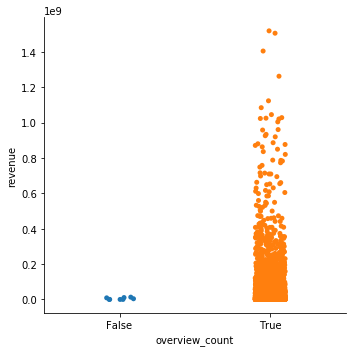

In [28]:
train_relevant['overview_count'] = train_relevant['overview'].apply(lambda x: False if pd.isnull(x) else True)

sns.catplot(x = 'overview_count', y = 'revenue', data=train_relevant)

## Next feature up is production_companies


In [29]:
#Using count function

train_relevant["production_companies_count"] = featureCounter(train_relevant, 'production_companies', 'num_of_production_companies')

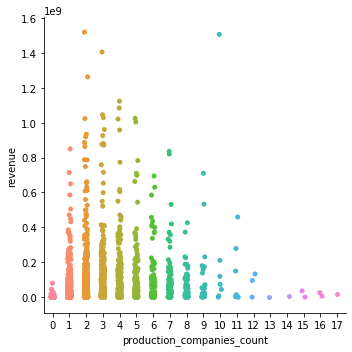

In [30]:
#Let's try and plot it with seaborn's catplot again
sns.catplot(x='production_companies_count', y='revenue', data=train_relevant)

### we see that fewer production companies is better, sometimes less is more

## Onto the next feature... production_countries!

In [31]:
#Using function
train_relevant['production_countries_count'] = featureCounter(train_relevant,'production_countries', 'num_of_prod_countries')

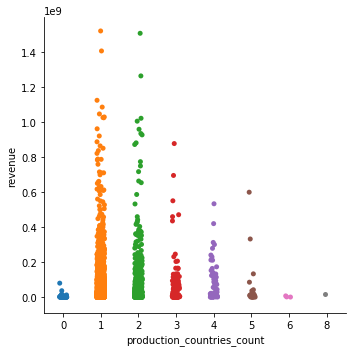

In [32]:
#Once more let's make a plot to see
sns.catplot(x='production_countries_count', y='revenue', data=train_relevant)

### Yet again we see that less is more

## Releasedate

### Let's split up realease date to release year, day and month. 

In [33]:
def transform_release_date(dataset):
    dataset[['release_month', 'release_day', 'release_year']] = dataset['release_date'].str.split('/', expand =True).replace(np.nan, 0).astype(int)
    dataset.loc[ (dataset['release_year'] <= 18) & (dataset['release_year'] < 100), "release_year"] += 2000
    dataset.loc[ (dataset['release_year'] > 18)  & (dataset['release_year'] < 100), "release_year"] += 1900   
    
    full_release_date_str = dataset['release_day'].map(str)+'-'+dataset['release_month'].map(str)+'-'+dataset['release_year'].map(str) 
    day_in_week = []
    for day in full_release_date_str:
        try:
            dt = pd.to_datetime(day)
            day_dt = dt.dayofweek
            day_in_week.append(day_dt)
        except:
            dt = pd.to_datetime("1-1-1970", format="%d-%m-%Y")
            day_dt = dt.dayofweek
            day_in_week.append(day_dt)
    dataset['release_dayofweek'] = day_in_week 

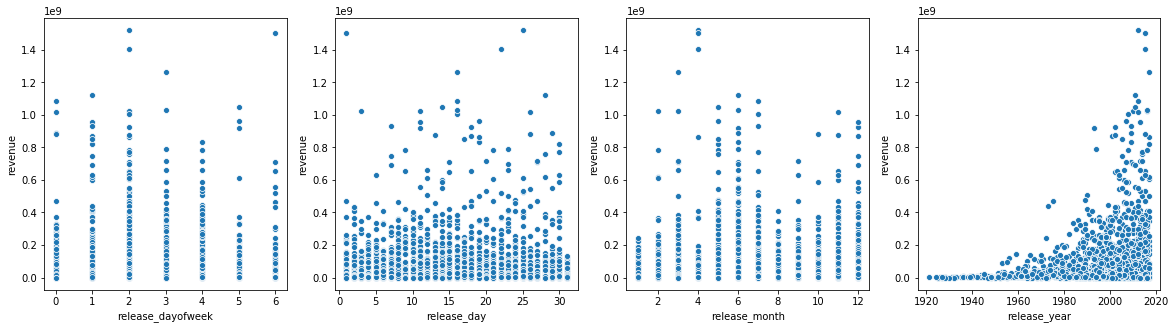

In [34]:
transform_release_date(train_relevant)
f, axis = plt.subplots(1,4, figsize=(20,5))
sns.scatterplot(x="release_dayofweek", y="revenue", data=train_relevant, ax=axis[0])
sns.scatterplot(x="release_day", y="revenue", data=train_relevant, ax=axis[1])
sns.scatterplot(x="release_month", y="revenue", data=train_relevant, ax=axis[2])
sns.scatterplot(x="release_year", y="revenue", data=train_relevant, ax=axis[3])

## CAST AND CREW

### Starting with Cast:

#### So the way I want to look at this is if the size of the cast/crew matters. I.e if a cast with 100 people generates more than a cast of 10. Let's try and plot this first:

In [35]:
train_relevant['cast_count'] = featureCounter(train_relevant,'cast', 'num_of_cast')

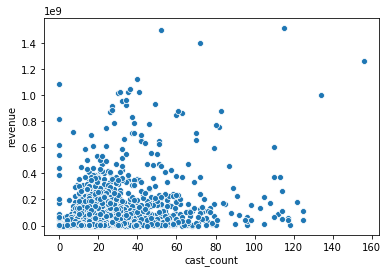

In [36]:
#Let's use scatterplot instead of catplot, there would be too many entries in catplot to make it usable...
sns.scatterplot(x='cast_count', y='revenue', data=train_relevant)

### Let's do the same for crew, I would suspect if there was a movie with well known actors and directors the generated revenue would be alot more, but for this time I would like to keep it a bit simpler

In [37]:
#let's do the same for crew
train_relevant['crew_count'] = featureCounter(train_relevant, 'crew', 'num_of_crew')

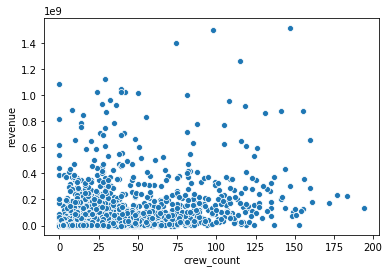

In [38]:
#Let's plot it with sns scatterplot again
sns.scatterplot(x='crew_count', y='revenue', data=train_relevant)

### Looks reasonable

## Keywords

### I'm thinking we're going through the same process of making a counter, as keywords will be determined by how many there is. I would imagine that having few important keywords will generate more revenue. Having too many keywords makes it hard to even remember. 

In [39]:
#Let's test the hypothesis above
train_relevant['keywords_count'] = featureCounter(train_relevant, 'Keywords', 'num_of_keywords')

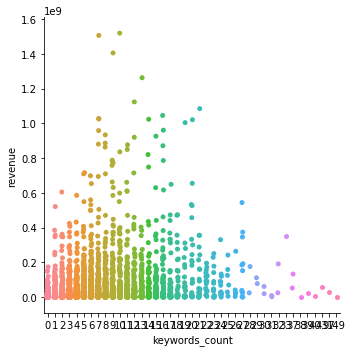

In [40]:
#As per usual catplot will be the best representation 
sns.catplot(x='keywords_count', y='revenue', data=train_relevant)

## Languages

### this is harder to make data prep with, because most movies has english as original_language, however there can be some other languages that generates revenue. Let's make a plot to see if there is.

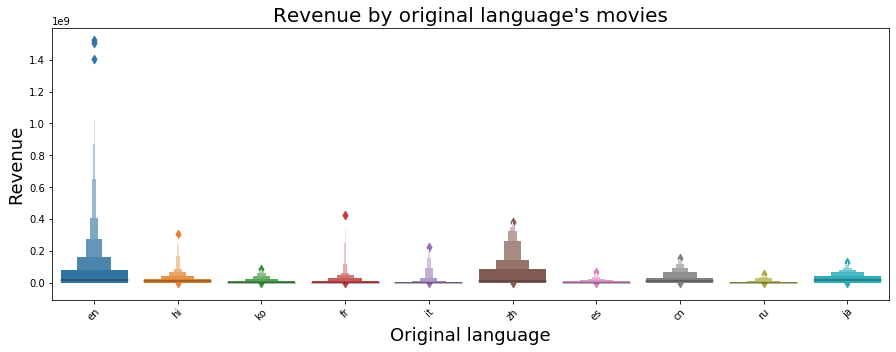

In [41]:
#this plot is universally used on the kaggle forums to repressent revenue by languages, I will borrow it for the sake of a better visual over languages

plt.figure(figsize=(15,5)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='original_language', y='revenue', 
                   data=train[(train['original_language'].isin((train['original_language'].value_counts()[:10].index.values)))])
g1.set_title("Revenue by original language's movies", fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Original language', fontsize=18) # Xlabel
g1.set_ylabel('Revenue', fontsize=18) #Ylabel

plt.show()

### en is the winner overall here, but zh also has some above average grossing movies. Fr seems to have one high grossing movie but is it enough to account for? Anyway, there seems to be another option since the language clearly plays a role and that is to use a OneHotEncoder for the language category. 

In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

lan_train = train.copy()
lan_test = test.copy()
data_all = pd.concat([lan_test,lan_train], sort=True)
lan_all_uni = data_all['original_language'].unique()

def one_hot_encode_languages(data):
    language_categories = [[data['original_language'].unique()]]
    col_trans = ColumnTransformer([('ori_lan', OneHotEncoder(categories=[lan_all_uni], dtype='bool'), ['original_language'])])
    enc_lan = col_trans.fit_transform(data)
    enc_lan_array = enc_lan.toarray()
    df_enc_lan = pd.DataFrame(enc_lan_array)
    return pd.concat([data,df_enc_lan],axis=1)

In [43]:
encoded_train_rel = one_hot_encode_languages(train_relevant)
encoded_train_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 71 columns):
budget                        3000 non-null int64
belongs_to_collection         604 non-null object
genres                        2993 non-null object
original_language             3000 non-null object
overview                      2992 non-null object
popularity                    3000 non-null float64
production_companies          2844 non-null object
production_countries          2945 non-null object
release_date                  3000 non-null object
runtime                       3000 non-null float64
tagline                       2403 non-null object
Keywords                      2724 non-null object
cast                          2987 non-null object
crew                          2984 non-null object
revenue                       3000 non-null int64
has_collection                3000 non-null bool
genre_count                   3000 non-null int64
overview_count                

## Only tagline remains with null values


In [44]:
#Tagline exists or not
encoded_train_rel['tagline_count'] = encoded_train_rel['tagline'].apply(lambda x: True if(not(pd.isnull(x))) else False)

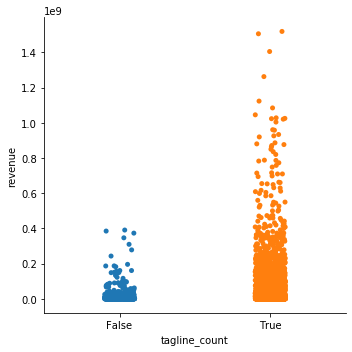

In [45]:
sns.catplot(x='tagline_count', y='revenue', data=encoded_train_rel)

In [46]:
encoded_train_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 72 columns):
budget                        3000 non-null int64
belongs_to_collection         604 non-null object
genres                        2993 non-null object
original_language             3000 non-null object
overview                      2992 non-null object
popularity                    3000 non-null float64
production_companies          2844 non-null object
production_countries          2945 non-null object
release_date                  3000 non-null object
runtime                       3000 non-null float64
tagline                       2403 non-null object
Keywords                      2724 non-null object
cast                          2987 non-null object
crew                          2984 non-null object
revenue                       3000 non-null int64
has_collection                3000 non-null bool
genre_count                   3000 non-null int64
overview_count                

# Pipeline for datacleaning
### We've done a lot of datacleaning, but let's make a function to transform it all into a pipeline

In [47]:
def pipeline(dataset):
    data_relevant = dataset.filter(['budget', 'belongs_to_collection', 'genres', 'original_language', 'overview','popularity', 'production_companies',
                                            'production_countries', 'release_date', 'runtime', 'tagline', 'Keywords', 'cast', 'crew'], axis =1)
    data_relevant['runtime'] = dataset['runtime'].fillna(dataset['runtime'].mean())
    data_relevant['has_collection'] = ~data_relevant['belongs_to_collection'].isnull()
    data_relevant['genres_count'] = featureCounter(data_relevant, 'genres', 'gn')     
    data_relevant['overview_count'] = data_relevant['overview'].apply(lambda x: False if pd.isnull(x) else True)
    data_relevant["production_companies_count"] = featureCounter(data_relevant, 'production_companies', 'num_of_production_companies')
    data_relevant['production_countries_count'] = featureCounter(data_relevant,'production_countries', 'num_of_prod_countries')
    transform_release_date(data_relevant)
    data_relevant['cast_count'] = featureCounter(data_relevant,'cast', 'num_of_cast')
    data_relevant['crew_count'] = featureCounter(data_relevant, 'crew', 'num_of_crew')
    data_relevant['tagline_count'] = data_relevant['tagline'].apply(lambda x: True if(not(pd.isnull(x))) else False)
    enc_data_rel = one_hot_encode_languages(data_relevant)
    final_dataset = enc_data_rel.select_dtypes(exclude=['object'])
    return final_dataset

In [48]:
data_prep = pipeline(train)
data_prep.head()

,budget,popularity,runtime,has_collection,genres_count,overview_count,production_companies_count,production_countries_count,release_month,release_day,...,34,35,36,37,38,39,40,41,42,43
0,14000000,6.575393,93.0,True,1,True,3,1,2,20,...,False,False,False,False,False,False,False,False,False,False
1,40000000,8.248895,113.0,True,4,True,1,1,8,6,...,False,False,False,False,False,False,False,False,False,False
2,3300000,64.299990,105.0,False,1,True,3,1,10,10,...,False,False,False,False,False,False,False,False,False,False
3,1200000,3.174936,122.0,False,2,True,0,1,3,9,...,False,False,False,False,False,False,False,False,False,False
4,0,1.148070,118.0,False,2,True,0,1,2,5,...,False,False,False,False,False,False,False,False,False,False


In [49]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 59 columns):
budget                        3000 non-null int64
popularity                    3000 non-null float64
runtime                       3000 non-null float64
has_collection                3000 non-null bool
genres_count                  3000 non-null int64
overview_count                3000 non-null bool
production_companies_count    3000 non-null int64
production_countries_count    3000 non-null int64
release_month                 3000 non-null int64
release_day                   3000 non-null int64
release_year                  3000 non-null int64
release_dayofweek             3000 non-null int64
cast_count                    3000 non-null int64
crew_count                    3000 non-null int64
tagline_count                 3000 non-null bool
0                             3000 non-null bool
1                             3000 non-null bool
2                             3000 non-null 

# 5. Explore different models

In [50]:
data_labels = train['revenue']
data_prepared = pipeline(train)
data_prepared.info()
data_labels_log = np.log1p(data_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 59 columns):
budget                        3000 non-null int64
popularity                    3000 non-null float64
runtime                       3000 non-null float64
has_collection                3000 non-null bool
genres_count                  3000 non-null int64
overview_count                3000 non-null bool
production_companies_count    3000 non-null int64
production_countries_count    3000 non-null int64
release_month                 3000 non-null int64
release_day                   3000 non-null int64
release_year                  3000 non-null int64
release_dayofweek             3000 non-null int64
cast_count                    3000 non-null int64
crew_count                    3000 non-null int64
tagline_count                 3000 non-null bool
0                             3000 non-null bool
1                             3000 non-null bool
2                             3000 non-null 

## linear regression

In [51]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, data_prepared, data_labels_log, scoring="neg_mean_squared_error", cv = 15) #generate the scores from cvs
rmse_scores = np.sqrt(-scores) #generate rmse for cvs
print(rmse_scores.mean())

2.4820311081351902


## Random Forrest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
rfr_reg = RandomForestRegressor(n_estimators=100)

In [53]:
scores = cross_val_score(rfr_reg, data_prepared, data_labels_log, scoring="neg_mean_squared_error", cv=15) #generate the scores from cvs
rmse_scores = np.sqrt(-scores) #generate rmse for cvs
print(rmse_scores.mean())

2.142150461416663


## Using lightgbm as 

In [54]:
import lightgbm as lgb #Se lgb documentation

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_labels_log, test_size=0.2)

In [56]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=2000, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 1.12854	training's l2: 1.2736	valid_1's rmse: 2.12685	valid_1's l2: 4.52351


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [57]:
lgb_model.fit(data_prepared, data_labels_log, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=2000, early_stopping_rounds=500)
y_pred=lgb_model.predict(X_test)

Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.20636	valid_0's l2: 1.4553	valid_1's rmse: 1.17713	valid_1's l2: 1.38564


### This looks promising.

## Gradient Booster

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(data_prepared, data_labels_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
scores = cross_val_score(gbr_reg, 
                         data_prepared, 
                         data_labels_log, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
gbr_reg_rmse_scores = np.sqrt(-scores)
print(gbr_reg_rmse_scores.mean())

2.1222872526869736


In [60]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[('gb', gbr_reg), ('rf', rfr_reg), ('lgb', lgb_model)])
voting_reg.fit(data_prepared, data_labels_log)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                   

In [61]:
scores = cross_val_score(voting_reg, data_prepared, data_labels_log, scoring="neg_mean_squared_error", cv=15) #generate the scores from cvs
rmse_scores = np.sqrt(-scores) #generate rmse for cvs
print(rmse_scores.mean())

2.0910881085207196


### Let's procede with the three: lightGBM model, RandomForrest and Gradient Boosting since they show best performance. The plan is then to combine these into a Voting regressor.
### An alternative to the models tried woulf be neural networks, since they tend to perform well, but that would mean scaling the dataset could be necessary as well. Let's procede with the models we've found so far

# 6. Fine tune models 

## WARNING! Gridsearch in this section takes a long time, so think twice before starting a cell.

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid_forest = [
    {
     'n_estimators':[100,500,800],
     'min_samples_split':[2,5,10],
     'bootstrap':[True,False], 
     'max_depth':[3,8,16], 
     'n_jobs':[-1], 
     'max_leaf_nodes':[5,10,20]
    }
]


In [64]:
forest_reg = RandomForestRegressor()

In [66]:
grid_search_fr = GridSearchCV(forest_reg, param_grid_forest, scoring='neg_mean_squared_error',cv=5, return_train_score=True)
grid_search_fr.fit(data_prepared, data_labels_log)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bootstrap': [True, False], 'm

In [67]:
grid_search_fr.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_leaf_nodes': 20,
 'min_samples_split': 5,
 'n_estimators': 100,
 'n_jobs': -1}

In [68]:
param_grid_gb = [
    {'n_estimators':[100,300,1000], 
     'learning_rate':[0.1,0.01], 
     'max_depth':[4,12,16], 
     'max_leaf_nodes':[5,20],
     'min_samples_leaf':[5,10]
    }
]

In [69]:
gb_reg = GradientBoostingRegressor()

In [71]:
grid_search_gb = GridSearchCV(gb_reg, param_grid_gb, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_gb.fit(data_prepared, data_labels_log)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [72]:
grid_search_gb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 10,
 'n_estimators': 300}

### So far so good, but let try and finetune the lgb regressor:

### NOTE: This finetuning was done manually by following the docs on the params for this model

In [73]:
#Parameter tuning for lightbgm is done manually according to the specs in documentation
#https://testlightgbm.readthedocs.io/en/latest/Parameters.html
#https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html

params = {
         'n_estimators':250000,
         'max_bin':255,
         'num_leaves': 4,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'min_child_samples': 100,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "metric": 'rmse',
         "subsample": .8,
         "lambda_l2": 0.1, 
         "verbosity": -1,
         'n_jobs':-1}

lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=5000, early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds
[5000]	training's rmse: 2.08458	valid_1's rmse: 2.15469
[10000]	training's rmse: 1.97574	valid_1's rmse: 2.10584
Early stopping, best iteration is:
[12990]	training's rmse: 1.92996	valid_1's rmse: 2.08609


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_bin=255, max_depth=5, metric='rmse', min_child_samples=100,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=250000, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [74]:
lgb_model.fit(data_prepared, data_labels_log, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=25000, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[25000]	valid_0's rmse: 1.82402	valid_1's rmse: 1.7468
[50000]	valid_0's rmse: 1.6798	valid_1's rmse: 1.57999
[75000]	valid_0's rmse: 1.57404	valid_1's rmse: 1.4627
[100000]	valid_0's rmse: 1.48642	valid_1's rmse: 1.3726
[125000]	valid_0's rmse: 1.41015	valid_1's rmse: 1.29583
[150000]	valid_0's rmse: 1.34341	valid_1's rmse: 1.23139
[175000]	valid_0's rmse: 1.28347	valid_1's rmse: 1.17553
[200000]	valid_0's rmse: 1.2292	valid_1's rmse: 1.12367
[225000]	valid_0's rmse: 1.17915	valid_1's rmse: 1.07689
[250000]	valid_0's rmse: 1.1329	valid_1's rmse: 1.03368
Did not meet early stopping. Best iteration is:
[249995]	valid_0's rmse: 1.1329	valid_1's rmse: 1.03368


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', lambda_l2=0.1, learning_rate=0.001,
              max_bin=255, max_depth=5, metric='rmse', min_child_samples=100,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=250000, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

### The LightGBM model looks very promising, although overfitting still is an option
### Let's have a look at the other finetuned regressors and their performance

In [75]:
rfr_best = RandomForestRegressor(bootstrap=True,
                                 max_depth=8,
                                 min_samples_split=5,
                                 max_leaf_nodes=20,
                                 n_estimators=100,
                                 n_jobs=-1,
                                 random_state=None)

In [86]:
gbr_best = GradientBoostingRegressor(learning_rate=0.1,
                                     max_depth=4,
                                     max_leaf_nodes=5,
                                     min_samples_leaf=10,
                                     n_estimators=300)

In [87]:
voting_final = VotingRegressor(estimators=[('gb', gbr_best), ('rf', rfr_best), ('lgb', lgb_model)])
voting_final.fit(data_prepared, data_labels_log)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=5,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=10,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                     

In [88]:
scores = cross_val_score(rfr_best, 
                         data_prepared, 
                         data_labels_log, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
gbr_reg_rmse_scores = np.sqrt(-scores)
print(gbr_reg_rmse_scores.mean())

2.2103551295236397


In [89]:
scores = cross_val_score(gbr_best, 
                         data_prepared, 
                         data_labels_log, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
gbr_reg_rmse_scores = np.sqrt(-scores)
print(gbr_reg_rmse_scores.mean())

2.0878056231783844


In [90]:
scores = cross_val_score(voting_final, 
                         data_prepared, 
                         data_labels_log, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
gbr_reg_rmse_scores = np.sqrt(-scores)
print(gbr_reg_rmse_scores.mean())

2.085929663539196


### It appears that they all perform pretty desent, but not as good as the LighGBM model so let's use that regressor for our solution.

# 7 + 8. present solution and manitain model

### It appears that the lgb regressor is the best working solution, so we'll go with that.

In [81]:
test_prep = pipeline(test)
test_prep.head()

,budget,popularity,runtime,has_collection,genres_count,overview_count,production_companies_count,production_countries_count,release_month,release_day,...,34,35,36,37,38,39,40,41,42,43
0,0,3.851534,90.0,True,4,True,0,2,7,14,...,False,False,False,False,False,False,False,False,False,False
1,88000,3.559789,65.0,False,2,True,1,1,5,19,...,False,False,False,False,False,False,False,False,False,False
2,0,8.085194,100.0,False,2,True,3,1,5,23,...,False,False,False,False,False,False,False,False,False,False
3,6800000,8.596012,130.0,False,3,True,3,2,9,4,...,False,False,False,False,False,False,False,False,False,False
4,2000000,3.217680,92.0,False,2,True,0,1,2,11,...,False,False,False,False,False,False,False,False,False,False


In [82]:
result_lgb_reg = lgb_model.predict(test_prep)

In [83]:
result_lgb_reg_norm = np.exp(result_lgb_reg)
np.mean(result_lgb_reg_norm)

59437991.85032875

In [84]:
result = pd.DataFrame(result_lgb_reg_norm)
result.columns = ['revenue']
result.index = test['id']
result.to_csv('./data/submission_5_lgb.csv')
len(result)

4398

## The lgb model gave a final score of 2.046 (RMSLE) on the Kaggle leaderboard, which is just a tad better than the voting regressor. 
## This most likely comes down to the fact the this model is in fact better trained with more precise hyperparameters. It must therefore be underperforming on the cross validation methods used in part 6.

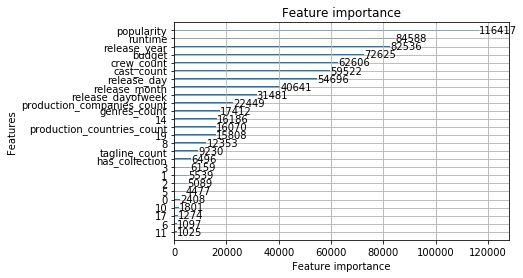

In [85]:
plot_lgb=lgb.plot_importance(lgb_model)

### We do see that the model weights popularity really high, which may be why it is overfitting. We are happy with the result for now